# Лабораторная работ №3 - "Подбор гиперпараметров модели" (ИНДИВИДУАЛЬНАЯ)

---

###### Выполнила: Люзина Мария 
###### Группа: М8О-307Б-23
###### Датасет (ссылка): [Качество воды](https://www.kaggle.com/datasets/adityakadiwal/water-potability)

---

# Задание:

0. Выбрать модель для обучения (Desicion tree, Random forest, SVM, KNN, Boosting)
1. Показать какие гиперпараметры есть у выбранной модели (В виде таблички).
2. Выбрать датасет для обучения и взависимости от модели подготовить данные
3. Подобрать гиперпараметры для модели и сравнить лучшие подборы, для (Grid Search, RandomSearch, Optuna)
4. На самом лучшем обучении (Grid Search, RandomSearch, Optuna) сделать калькулятор, который показывает `локальную интерпретацию` с помощью [LIME](https://habr.com/ru/companies/otus/articles/779430/) и `глобальную интерпретацию` с помощью [SHAP](https://habr.com/ru/companies/ods/articles/599573/).

    [Доп статья](https://habr.com/ru/companies/wunderfund/articles/739744/)

# Формат сдачи

1. Защита преподавателю
2. Презентация о проделанной работе (10-15 слайдов)
3. Файл `FIO_lr3.ibynb`

# Описание датасета

Датасет Water Potability представляет собой бинарную задачу классификации: предсказание пригодности воды для питья (Potability: 0 — не пригодна, 1 — пригодна). Ключевые характеристики на основе описания датасета:
* Размер: 3276 экземпляров (строк).
* Признаки: 9 числовых фич (ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity). Нет категориальных переменных.
* Целевая переменная: Potability (бинарная: 0/1).
* Распределение классов: Сбалансированное — примерно 1998 (61%) для класса 0 и 1278 (39%) для класса 1 (лёгкий дисбаланс, но не критический).
* Есть пропуски (missing values) в нескольких фичах (ph, Sulfate, Trihalomethanes — около 10–15% на фичу).

# Выбор модели
Для данного датасета лучшей моделью будет Boosting, например, XGBoost. Причины такого выбора:
* Высокая точность: Boosting excels в табличных задачах с числовыми фичами, особенно с лёгким дисбалансом.
* Устойчивость: Хорошо справляется с пропусками (нативная поддержка в XGBoost) и шумом в данных (ph, Turbidity — химические метрики с вариацией).
* Практичность: Быстрое обучение на 3k+ сэмплах, встроенная feature importance для интерпретации (например, Turbidity и Organic_carbon часто топ-фичи).

# Гиперпараметры XGBoost

In [2]:
import pandas as pd
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    enable_categorical=False
)

param_descriptions = {
    "n_estimators":      "Количество деревьев",
    "learning_rate":     "Скорость обучения (eta)",
    "max_depth":         "Максимальная глубина дерева",
    "min_child_weight":  "Мин. сумма весов в листе",
    "gamma":             "Мин. снижение функции потерь для сплита",
    "subsample":         "Доля объектов для каждого дерева",
    "colsample_bytree":  "Доля признаков для каждого дерева",
    "reg_alpha":         "L1-регуляризация",
    "reg_lambda":        "L2-регуляризация",
    "scale_pos_weight":  "Баланс классов (positive/negative)",
    "random_state":      "Сид для воспроизводимости",
    "n_jobs":            "Количество ядер CPU (-1 = все)",
    "tree_method":       "Алгоритм построения деревьев",
    "enable_categorical":"Автоопределение категорий (False → безопасно с NaN)",
}

data = []
default_params = XGBClassifier().get_params()

for param, desc in param_descriptions.items():
    curr = model.get_params().get(param, "-")
    default = default_params.get(param)
    data.append({
        "Гиперпараметр": param,
        "Значение": curr,
        "По умолчанию": "Да" if curr == default else "Нет",
        "Описание": desc
    })

df_params = pd.DataFrame(data)
df_params = df_params.sort_values(by="По умолчанию").reset_index(drop=True)

df_params.style\
    .set_caption("Гиперпараметры XGBoost")\
    .set_table_styles([{'selector': 'caption', 
                        'props': 'font-size: 18px; font-weight: bold; color: #2c3e50; margin-bottom: 10px;'}])\
    .background_gradient(cmap="Blues")

,Гиперпараметр,Значение,По умолчанию,Описание
0,min_child_weight,None,Да,Мин. сумма весов в листе
1,gamma,None,Да,Мин. снижение функции потерь для сплита
2,scale_pos_weight,None,Да,Баланс классов (positive/negative)
3,enable_categorical,False,Да,Автоопределение категорий (False → безопасно с NaN)
4,n_estimators,500,Нет,Количество деревьев
5,learning_rate,0.020000,Нет,Скорость обучения (eta)
6,max_depth,6,Нет,Максимальная глубина дерева
7,subsample,0.800000,Нет,Доля объектов для каждого дерева
8,colsample_bytree,0.800000,Нет,Доля признаков для каждого дерева
9,reg_alpha,0.100000,Нет,L1-регуляризация


# Подготовка датасета

Необходимые библиотеки

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Импортируем датасет

In [4]:
path = 'water_potability.csv'
df = pd.read_csv(path)

df.head(3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Пропуски

In [6]:
print("Пропущенные значения:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_table = pd.DataFrame({"Пропуски": missing, "%": missing_pct})
display(missing_table[missing_table["Пропуски"] > 0])

Пропущенные значения:


,Пропуски,%
ph,491,14.99
Sulfate,781,23.84
Trihalomethanes,162,4.95


Пропуски трогать не будем, модель XGBoost с методом `tree_method='hist'` сам с ними поработает

Баланс классов

C:\Users\user\AppData\Local\Temp\ipykernel_7968\2668342832.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Potability', palette="Set2")


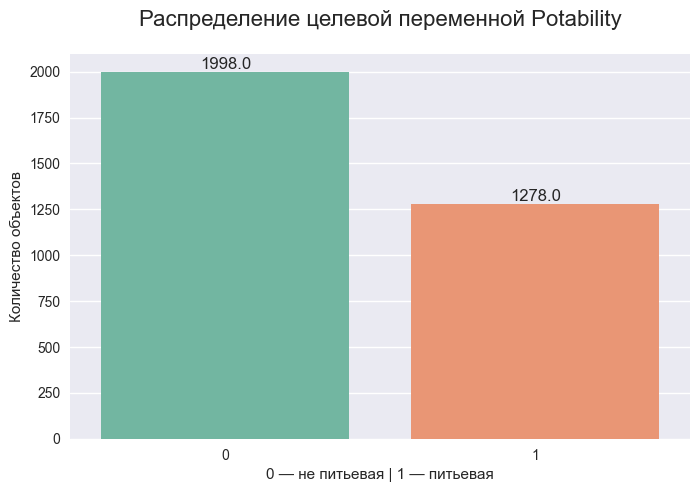


Процент питьевой воды (класс 1): 39.0%


In [7]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

plt.figure(figsize=(8,5))
ax = sns.countplot(data=df, x='Potability', palette="Set2")
plt.title("Распределение целевой переменной Potability", fontsize=16, pad=20)
plt.xlabel("0 — не питьевая | 1 — питьевая")
plt.ylabel("Количество объектов")
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width()/2, p.get_height() + 20),
                ha='center', fontsize=12)
plt.show()

print(f"\nПроцент питьевой воды (класс 1): {(df['Potability'].mean()*100):.1f}%")

Разделение на обучающую и тестовую выборки

In [8]:
X = df.drop("Potability", axis=1)
y = df["Potability"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка:    {X_test.shape}")

Обучающая выборка: (2620, 9)
Тестовая выборка:    (656, 9)


# Подбор гиперпараметров


Необходимые библиотеки

In [9]:
import time
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
import optuna
import warnings
warnings.filterwarnings("ignore")

In [10]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight для борьбы с дисбалансом = {scale_pos_weight:.2f}\n")

scale_pos_weight для борьбы с дисбалансом = 1.56



Единая модель с базовыми настройками

In [11]:
def get_xgb():
    return XGBClassifier(
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        enable_categorical=False,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss'
    )

Общие пространства поиска

In [12]:
param_grid = {
    'n_estimators'     : [400, 600, 800],
    'learning_rate'    : [0.05, 0.08, 0.1],
    'max_depth'        : [5, 6, 7],
    'min_child_weight' : [2, 4],
    'subsample'        : [0.8, 1.0],
    'colsample_bytree' : [0.8, 0.9],
    'reg_alpha'        : [0, 0.1],
    'reg_lambda'       : [1.0, 1.5]
}

results = []

## GridSearchCV


In [13]:
from sklearn.model_selection import GridSearchCV

start = time.time()
grid = GridSearchCV(
    get_xgb(),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)
grid.fit(X_train, y_train)
grid_time = time.time() - start

grid_best = grid.best_estimator_
grid_auc = roc_auc_score(y_test, grid_best.predict_proba(X_test)[:,1])
results.append({
    "Метод": "GridSearchCV",
    "ROC-AUC": round(grid_auc, 4),
    "Время": f"{grid_time//60:.0f}м {grid_time%60:.0f}с",
    "Лучшие параметры": grid.best_params_
})

## RandomizedSearchCV

In [14]:
from sklearn.model_selection import RandomizedSearchCV

start = time.time()
random = RandomizedSearchCV(
    get_xgb(),
    param_grid,
    n_iter=100,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)
random.fit(X_train, y_train)
rand_time = time.time() - start

rand_best = random.best_estimator_
rand_auc = roc_auc_score(y_test, rand_best.predict_proba(X_test)[:,1])
results.append({
    "Метод": "RandomizedSearchCV",
    "ROC-AUC": round(rand_auc, 4),
    "Время": f"{rand_time//60:.0f}м {rand_time%60:.0f}с",
    "Лучшие параметры": random.best_params_
})

## Optuna

In [15]:
def objective(trial):
    params = {
        'n_estimators'     : trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate'    : trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth'        : trial.suggest_int('max_depth', 3, 10),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
        'gamma'            : trial.suggest_float('gamma', 0, 0.5),
        'subsample'        : trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 0, 2),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 0, 2),
    }
    model = get_xgb()
    model.set_params(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1).mean()
    return score

start = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=60, show_progress_bar=True)
optuna_time = time.time() - start

optuna_best = get_xgb()
optuna_best.set_params(**study.best_params)
optuna_best.fit(X_train, y_train)
optuna_auc = roc_auc_score(y_test, optuna_best.predict_proba(X_test)[:,1])

results.append({
    "Метод": "Optuna",
    "ROC-AUC": round(optuna_auc, 4),
    "Время": f"{optuna_time//60:.0f}м {optuna_time%60:.0f}с",
    "Лучшие параметры": study.best_params
})

[I 2025-11-22 17:28:42,496] A new study created in memory with name: no-name-52e169d0-3894-4251-bb54-f7e5f0688809


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-11-22 17:28:44,755] Trial 0 finished with value: 0.6672090992764181 and parameters: {'n_estimators': 598, 'learning_rate': 0.07939196645364663, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.10299059948007588, 'subsample': 0.7085109327247439, 'colsample_bytree': 0.9371788519667466, 'reg_alpha': 0.5692855855530439, 'reg_lambda': 1.7892860212104686}. Best is trial 0 with value: 0.6672090992764181.
[I 2025-11-22 17:28:45,595] Trial 1 finished with value: 0.6511117362401035 and parameters: {'n_estimators': 671, 'learning_rate': 0.20891249443992663, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.08126234155025736, 'subsample': 0.9190763662288277, 'colsample_bytree': 0.7188676946156429, 'reg_alpha': 0.7353706136203508, 'reg_lambda': 0.22686108964914786}. Best is trial 0 with value: 0.6672090992764181.
[I 2025-11-22 17:28:45,859] Trial 2 finished with value: 0.6544552703574358 and parameters: {'n_estimators': 259, 'learning_rate': 0.06647055302420744, 'max_depth': 3, 'min_child_

### Итоговая таблица сравнения

In [16]:
df_results = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
display(df_results.sort_values("ROC-AUC", ascending=False).reset_index(drop=True))


,Метод,ROC-AUC,Время,Лучшие параметры
0,Optuna,0.6531,1м 48с,"{'n_estimators': 875, 'learning_rate': 0.01041306722392239, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.01553738740221368, 'subsample': 0.8000176800199313, 'colsample_bytree': 0.9726697311393013, 'reg_alpha': 1.5865841956546338, 'reg_lambda': 0.1513615728692934}"
1,RandomizedSearchCV,0.6442,1м 44с,"{'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0, 'n_estimators': 400, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.8}"
2,GridSearchCV,0.6350,14м 13с,"{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'subsample': 0.8}"


Модель Optuna оказалась лучше всех по следующим причинам:
* Самое широкое и гибкое пространство поиска
* Байесовская оптимизация умнее случайного поиска
* Нашла более тонкую настройку: learning_rate очень маленькое, но зато n_estimators большое → модель медленно, но точно учится.

# Интерпретация + калькулятор

Необходимые библиотеки

In [17]:
import shap
from shap.plots import colors
from lime import lime_tabular
import ipywidgets as widgets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

Подключение модели и подготовка данных

In [18]:
model = optuna_best

X_test_clean = X_test.reset_index(drop=True)
y_test_clean = y_test.reset_index(drop=True)

Глобальная интерпретация (SHAP)

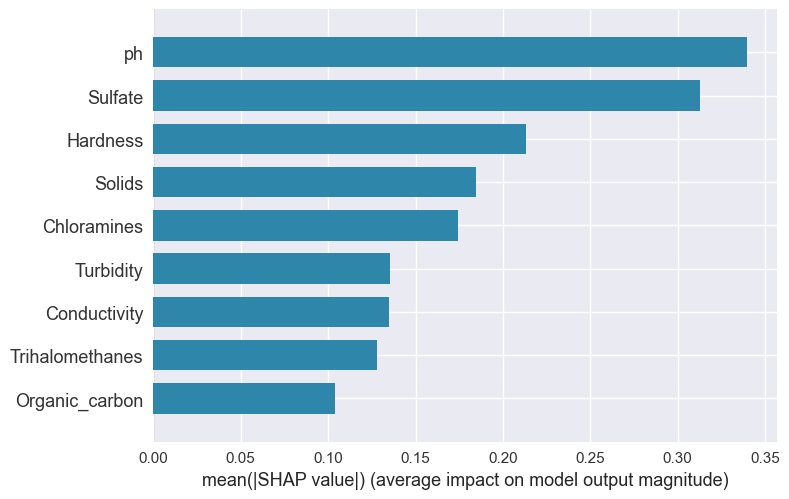

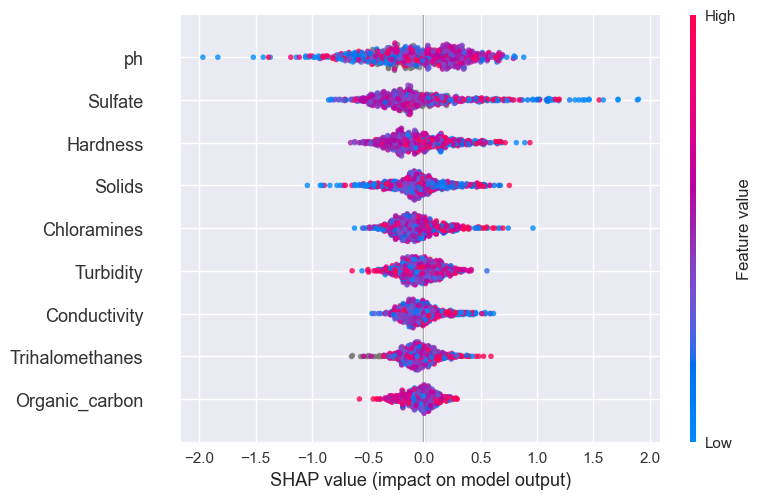

In [19]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_clean)

if isinstance(shap_values, list):
    shap_values = shap_values[1]

shap.summary_plot(shap_values, X_test_clean, plot_type="bar", color="#2E86AB")
shap.summary_plot(shap_values, X_test_clean, alpha=0.8)


Калькулятор

In [ ]:
def water_quality_calculator(
    ph=7.0, Hardness=200, Solids=20000, Chloramines=7.0,
    Sulfate=330, Conductivity=400, Organic_carbon=10,
    Trihalomethanes=70, Turbidity=4.0
):
    x = np.array([[ph, Hardness, Solids, Chloramines, Sulfate,
                   Conductivity, Organic_carbon, Trihalomethanes, Turbidity]])
    
    prob = model.predict_proba(x)[0][1]
    verdict = "ПИТЬЕВАЯ" if prob >= 0.5 else "НЕ ПИТЬЕВАЯ"
    
    print(f"Вероятность питьевой воды: {prob:.1%}")
    print(f"РЕШЕНИЕ МОДЕЛИ: {verdict}\n")
    
    # SHAP в реальном времени
    sv = explainer.shap_values(x)
    if isinstance(sv, list):
        sv = sv[1][0]
    shap.initjs()
    display(shap.force_plot(
        explainer.expected_value,
        sv,
        x,
        feature_names=X_train.columns,
        matplotlib=False,
        show=False
    ))
    
    lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    class_names=['НЕ питьевая', 'Питьевая'],
    mode='classification',
    discretize_continuous=False
    )
    # LIME в реальном времени
    exp = lime_explainer.explain_instance(
        x[0],
        model.predict_proba,
        num_features=9
    )
    exp.show_in_notebook()

# Запуск калькулятора
widgets.interact(water_quality_calculator,
    ph=widgets.FloatSlider(min=0, max=14, step=0.1, value=7.0, description='pH'),
    Hardness=widgets.FloatSlider(min=50, max=400, step=10, value=200, description='Hardness'),
    Solids=widgets.FloatSlider(min=100, max=100000, step=1000, value=20000, description='Solids'),
    Chloramines=widgets.FloatSlider(min=0, max=15, step=0.1, value=7.0, description='Chloramines'),
    Sulfate=widgets.FloatSlider(min=100, max=500, step=10, value=330, description='Sulfate'),
    Conductivity=widgets.FloatSlider(min=100, max=1000, step=10, value=400, description='Conductivity'),
    Organic_carbon=widgets.FloatSlider(min=0, max=30, step=0.5, value=10, description='Organic carbon'),
    Trihalomethanes=widgets.FloatSlider(min=0, max=150, step=5, value=70, description='Trihalomethanes'),
    Turbidity=widgets.FloatSlider(min=0, max=10, step=0.1, value=4.0, description='Turbidity')
)

interactive(children=(FloatSlider(value=7.0, description='pH', max=14.0), FloatSlider(value=200.0, description…

<function __main__.water_quality_calculator(ph=7.0, Hardness=200, Solids=20000, Chloramines=7.0, Sulfate=330, Conductivity=400, Organic_carbon=10, Trihalomethanes=70, Turbidity=4.0)>